In [1]:
import os
import json
import numpy as np
import pandas as pd
from gensim import corpora
from gensim.models import Word2Vec

In [2]:
with open('data/train.json',encoding='utf-8-sig') as f:
    train_dict = json.load(f)
    
train_df = pd.DataFrame.from_dict(train_dict)

# tag 전처리

In [3]:
from itertools import chain
from collections import defaultdict
import pprint

# train dataframe tag 컬럼의 모든 tag들 (중복포함)
tags_all = train_df['tags'].tolist()

# 태그의 빈도수를 가진 dict, Counter 써도 됨
tags_frequency = defaultdict(int)

# 특정 tag가 나올 때마다 1더하기
for tags in tags_all:
    for tag in tags:
        tags_frequency[tag] += 1

# tag 중에 빈도수가 1번 이상 나오고, 플레이리스트 당 tag가 1개 이상인 것들만 포함
tags_more_than_one = [[tag for tag in tags if tags_frequency[tag] > 1 ] for tags in tags_all if len(tags) > 1]

In [4]:
# 전처리 후 태그들의 갯수
len(tags_more_than_one)

87829

# tag 딕셔너리 만들기 

In [5]:
# 전처리한 tag들을 가지고 gensim corpora 딕셔너리 만들기
tag_unique_dict = corpora.Dictionary(tags_more_than_one)

In [6]:
# gensim 딕셔너리의 token2id 함수를 이용해서 {태그:id} 딕셔너리 만들기
tags_to_id = tag_unique_dict.token2id

In [7]:
# 위 딕셔너리 key, value 반전해서 {id:태그} 딕셔너리 만들기
id_to_tags = {v:k for k,v in tags_to_id.items()}

# Word2Vec 모델 생성

In [8]:
# 벡터 크기 100으로 해서 window=4 주고 Word2Vec 학습
w2v_model = Word2Vec(sentences=tags_more_than_one,vector_size=100,window=4,min_count=1,workers=4,sg=1)

In [9]:
# w2v 모델 저장
w2v_model.save('./models/w2v_model')

In [10]:
# w2v 모델 불러오기
w2v_model = Word2Vec.load('./models/w2v_model')

In [11]:
# 락과 관련된 태그 10개
sims = w2v_model.wv.most_similar('락', topn=10)
sims

[('록', 0.9223761558532715),
 ('메탈', 0.8095712065696716),
 ('밴드', 0.7833627462387085),
 ('참이슬', 0.7639904618263245),
 ('JRock', 0.7564314603805542),
 ('얼터너티브', 0.7556256651878357),
 ('Rock', 0.7513983845710754),
 ('모던록', 0.7481400370597839),
 ('모던락', 0.7478722929954529),
 ('헤비메탈', 0.7462851405143738)]

# Word2Vec 모델 활용

## 준비물

In [12]:
# word2vec {태그:id} 딕셔너리 만들기
tag_to_index = w2v_model.wv.key_to_index

In [13]:
# word2vec key만 뽑기
index_to_key = w2v_model.wv.index_to_key

In [14]:
# word2vec 에서 나온 모든 벡터를 list에 담기

vectors = []

for i in range(len(w2v_model.wv)):
    vectors.append(w2v_model.wv[i])

In [15]:
# word2vec {id:태그} 딕셔너리 만들기
index_to_key_dict = dict(zip(range(len(index_to_key)),index_to_key))

## 시각화

In [16]:
# 시각화용 파일 저장
from gensim.models import KeyedVectors

w2v_model.wv.save_word2vec_format('tag_w2v')

In [17]:
# 시각화용 파일 변환
!python -m gensim.scripts.word2vec2tensor -i tag_w2v -o tag_wv2

2021-09-08 17:04:56,048 - word2vec2tensor - INFO - running C:\Users\mkitL\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\scripts\word2vec2tensor.py -i tag_w2v -o tag_wv2
2021-09-08 17:04:56,048 - keyedvectors - INFO - loading projection weights from tag_w2v
2021-09-08 17:04:57,007 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (11701, 100) matrix of type float32 from tag_w2v', 'binary': False, 'encoding': 'utf8', 'datetime': '2021-09-08T17:04:56.933923', 'gensim': '4.0.1', 'python': '3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'load_word2vec_format'}
2021-09-08 17:04:57,705 - word2vec2tensor - INFO - 2D tensor file saved to tag_wv2_tensor.tsv
2021-09-08 17:04:57,705 - word2vec2tensor - INFO - Tensor metadata file saved to tag_wv2_metadata.tsv
2021-09-08 17:04:57,706 - word2vec2tensor - INFO - finished running word2vec2tensor.py


## 군집화

### 최적 클러스터 갯수 찾기

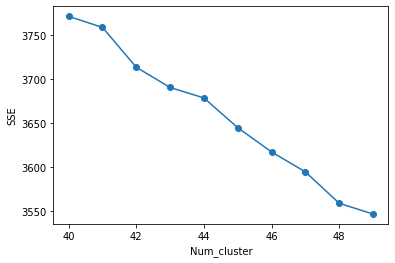

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
def elbow(x):
    sse = []
    for i in range(40,50):
        km = KMeans(n_clusters=i, init = 'k-means++' , random_state=123)
        km.fit(x)
        sse.append(km.inertia_)
    plt.plot(range(40,50),sse,marker='o')
    plt.xlabel('Num_cluster')
    plt.ylabel('SSE')
    plt.show()
    
elbow(vectors)

### 최적 클러스터 갯수를 통해 훈련 및 예측

In [ ]:
km = KMeans(n_clusters=100, init = 'k-means++' , random_state=123)
prediction = km.fit_predict(vectors)

In [ ]:
# {id:예측내용}의 딕셔너리 만들기
id_prediction = dict(zip(range(len(prediction)),prediction))

In [ ]:
# {태그:예측내용}의 딕셔너리 만들기
tag_prediction = {index_to_key_dict[k]:v for k,v in id_prediction.items()}
tag_prediction

In [ ]:
# 클러스터 id를 넣으면 클러스터 내의 태그들을 반환 해주는 함수
def cluster_id_to_items(cluster_id):
    global tag_prediction
    tag_list = []
    for k,v in tag_prediction.items():
        if v == cluster_id:
            tag_list.append(k)
            
    return tag_list

In [ ]:
cluster_id_to_items(23)